# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [2]:
# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureTest.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 188) Taille du dataset de test ECG : (1000, 188)
Taille de la base d apprentissage Features : (4000, 156) Taille du dataset de test Features : (1000, 156)


In [3]:
label_name = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

### Isolation des caractéristiques

In [4]:
# Isolation des caractéristiques

# Temporel
DataFeatureAppTemp = DataFeatureApp[:, :31]
DataFeatureTestTemp = DataFeatureTest[:, :31]

# Statistique
DataFeatureAppStat = DataFeatureApp[:, 31:45]
DataFeatureTestStat = DataFeatureTest[:, 31:45]

# Spectrale
DataFeatureAppSpec = DataFeatureApp[:, 45:156]
DataFeatureTestSpec = DataFeatureTest[:, 45:156]

print(DataFeatureAppTemp.shape)
print(DataFeatureTestTemp.shape)
print(DataFeatureAppStat.shape)
print(DataFeatureTestStat.shape)
print(DataFeatureAppSpec.shape)
print(DataFeatureTestSpec.shape)

(4000, 31)
(1000, 31)
(4000, 14)
(1000, 14)
(4000, 111)
(1000, 111)


## Vecteur médian des caractéristiques pour chaque classe

In [5]:
# Calculer le vecteur médian des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques avec numpy
unique_labels = np.unique(LabelF_train)
print("Classes uniques :", unique_labels)

for label in unique_labels:
  Data_App_Temp= DataFeatureApp[:,:32]
  # Filtrer les données pour la classe actuelle
  class_features = Data_App_Temp[np.array(LabelF_train) == label]
    # Calculer la médiane des caractéristiques pour cette classe
  class_median = np.median(class_features, axis=0)  # Utilisation de np.median()
  class_feature_medians[label] = class_median

# Afficher les résultats
#for label, median_vector in class_feature_medians.items():
   # print(f"Vecteur médian pour la classe {label} : {median_vector}")

Classes uniques : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

In [6]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [7]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

In [9]:
def assign_winners(mylist):
    print(mylist)
    ### recuperer la valeur max de chaque list avec index
    max_values_with_indices = [(max(sublist), sublist.index(max(sublist))) for sublist in mylist]


    ### comparer les valeur max et leur index ; recommencer si deux index se telescope 
        ### => le plus faible doit recommencer et se comparer à tout le monde pour voir s'il gagne ou pas et ainsi de suite
    for i in range(len(max_values_with_indices)):
        for j in range(i + 1, len(max_values_with_indices)):
            if max_values_with_indices[i][1] == max_values_with_indices[j][1]:  # Même index
                print("on a des egalité")
                if max_values_with_indices[i][0] > max_values_with_indices[j][0]:
                    index_of = mylist[j].index( max_values_with_indices[j][0])
                    mylist[j][index_of] = 0 
                    print(f"Tuple {max_values_with_indices[i]} est plus grand que {max_values_with_indices[j]}")
                    max_values_with_indices = assign_winners(mylist)
                    
                else:
                    index_of = mylist[i].index( max_values_with_indices[i][0]) 
                    mylist[j][index_of] = 0
                    print(f"Tuple {max_values_with_indices[j]} est plus grand que {max_values_with_indices[i]}")
                    max_values_with_indices = assign_winners(mylist)
    return max_values_with_indices
    

## test my correspondance 
def count_elem(l1,l2,index):
    l1 = set(l1)
    l2 = set (l2)
    all_lists = [l1,l2]

    # Comparer chaque paire de listes
    for i in range(len(all_lists)):
        for j in range(i + 1, len(all_lists)):
            common_elements = all_lists[i].intersection(all_lists[j])
            L_count[index].append(len(common_elements))
    #print(f"element en commun {len(common_elements)}")
    return (len(common_elements))

def true_label(L_pred, y_train):
    index_lpred = []
    index_y_train = []
    match_L = []
    global L_count 
    L_count = [[] for _ in range(5)]
    
    ### recuperer les index de chaque  classes prédites  et classes veritables
    for i in range(0,5):
        index_lpred.append(np.where(L_pred == i)[0])
        index_y_train.append(np.where(y_train == i)[0])

### correspondances entre les index d'une classe A avec les index d'une classe B (plus grand nombre)
    ### parcourir chaque classe d'index et faire un compte de ce qui en ont le plus
    for i in range(0,5):
        for j in range(0,5):
            match_L.append(count_elem(index_lpred[i],index_y_train[j],i))
    #print(L_count)

    w = assign_winners(L_count)
    print(w)

### mettre les nouvelles classes
    for i, indices in enumerate(index_lpred):
        class_value = w[i][1]  # Récupère la 2ᵉ valeur du tuple
        for index in indices:
            L_pred[index] = class_value    
    return L_pred
            
            



# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



information (alban) : On veut comparer les caracteristiques du jeu de test aux valeurs médianes (par exemple)   du jeu de test pour chaque classe ( car on sait a quel classe chaque battement appartient)

On a un ensemble de caracteristique par battement et on veut les comparér via l'algo DTW, celui dont on est le plus proche alors on peut le classer comme étant un battement de ce type la ( il faut comparer a chaque classe ).

In [11]:
from math import *
import numpy as np
import sys

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données d'apprentissage et de test
scaler = StandardScaler()
DataFeatureApp_normalized = scaler.fit_transform(DataFeatureApp)
DataFeatureTest_normalized = scaler.transform(DataFeatureTest)

In [13]:
# Calculer les vecteurs médians des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques
unique_labels = np.unique(LabelF_train)

for label in unique_labels:
    # Filtrer les données pour la classe actuelle
    class_features = DataFeatureApp_normalized[np.array(LabelF_train) == label]
    
    # Calculer la médiane des caractéristiques pour cette classe
    class_median = np.median(class_features, axis=0)
    class_feature_medians[label] = class_median

# Afficher les vecteurs médians pour chaque classe
for label, median in class_feature_medians.items():
    print(f"Classe {label} : Médiane calculée avec {len(median)} caractéristiques")

Classe 0.0 : Médiane calculée avec 156 caractéristiques
Classe 1.0 : Médiane calculée avec 156 caractéristiques
Classe 2.0 : Médiane calculée avec 156 caractéristiques
Classe 3.0 : Médiane calculée avec 156 caractéristiques
Classe 4.0 : Médiane calculée avec 156 caractéristiques


In [14]:
def DTW(A, B, d, w0=1, w1=1, w2=1):
    """
    Algorithme DTW avec poids ajustables pour aligner deux séries temporelles.

    Args:
        A (list or np.ndarray): Première série temporelle.
        B (list or np.ndarray): Deuxième série temporelle.
        d (function): Fonction de distance locale entre deux points.
        w0 (int): Poids pour l'insertion.
        w1 (int): Poids pour la correspondance.
        w2 (int): Poids pour la suppression.

    Returns:
        float: Score d'alignement.
        list: Chemin optimal d'alignement.
    """
    N, M = len(A), len(B)
    g = np.full((N + 1, M + 1), float('inf'))
    g[0, 0] = 0

    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = d(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * cost,
                g[i - 1, j - 1] + w1 * cost,
                g[i, j - 1] + w2 * cost
            )

    S = g[N, M] / (N + M)
    path = []
    i, j = N, M
    while i > 0 or j > 0:
        path.append((i - 1, j - 1))
        if i > 0 and j > 0 and g[i, j] == g[i - 1, j - 1] + w1 * d(A[i - 1], B[j - 1]):
            i -= 1
            j -= 1
        elif i > 0 and g[i, j] == g[i - 1, j] + w0 * d(A[i - 1], B[j - 1]):
            i -= 1
        else:
            j -= 1

    path.reverse()
    return S, path

## Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [15]:
TAILLE_TEST = DataECGTest.shape[0]  # Nombre d'exemples de test
N_CLASSES = 5  

In [16]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

In [17]:
# Initialiser la partition avec deux colonnes : classe réelle et classe prédite
PartitionDTW = np.zeros((TAILLE_TEST, 2))

# Appliquer DTW pour chaque vecteur de test
for i, test_vector in enumerate(DataFeatureTest_normalized):
    best_score = float('inf')  # Initialiser le meilleur score à l'infini
    best_label = None  # Label correspondant au meilleur score

    for label, class_median in class_feature_medians.items():
        # Calcul du score DTW entre le vecteur de test et le vecteur médian de la classe
        score, _ = DTW(test_vector, class_median, euclidean_distance)

        # Vérifier si c'est le meilleur score
        if score < best_score:
            best_score = score
            best_label = label

    # Enregistrer la classe réelle et prédite dans PartitionDTW
    PartitionDTW[i, 0] = LabelF_test[i]  # Classe réelle
    PartitionDTW[i, 1] = best_label  # Classe prédite

    # Afficher le score et la classe prédite pour l'instance actuelle
    print(f"Vecteur de test {i + 1} : Meilleur score = {best_score:.4f}, Classe prédite = {best_label}")

Vecteur de test 1 : Meilleur score = 0.2435, Classe prédite = 1.0
Vecteur de test 2 : Meilleur score = 0.4216, Classe prédite = 4.0
Vecteur de test 3 : Meilleur score = 0.3558, Classe prédite = 2.0
Vecteur de test 4 : Meilleur score = 0.2207, Classe prédite = 4.0
Vecteur de test 5 : Meilleur score = 0.2645, Classe prédite = 1.0
Vecteur de test 6 : Meilleur score = 0.1937, Classe prédite = 2.0
Vecteur de test 7 : Meilleur score = 0.1872, Classe prédite = 0.0
Vecteur de test 8 : Meilleur score = 0.3351, Classe prédite = 4.0
Vecteur de test 9 : Meilleur score = 0.1039, Classe prédite = 2.0
Vecteur de test 10 : Meilleur score = 0.2587, Classe prédite = 1.0
Vecteur de test 11 : Meilleur score = 0.1907, Classe prédite = 2.0
Vecteur de test 12 : Meilleur score = 0.1738, Classe prédite = 1.0
Vecteur de test 13 : Meilleur score = 0.2069, Classe prédite = 3.0
Vecteur de test 14 : Meilleur score = 0.1970, Classe prédite = 4.0
Vecteur de test 15 : Meilleur score = 0.0652, Classe prédite = 3.0
Vect

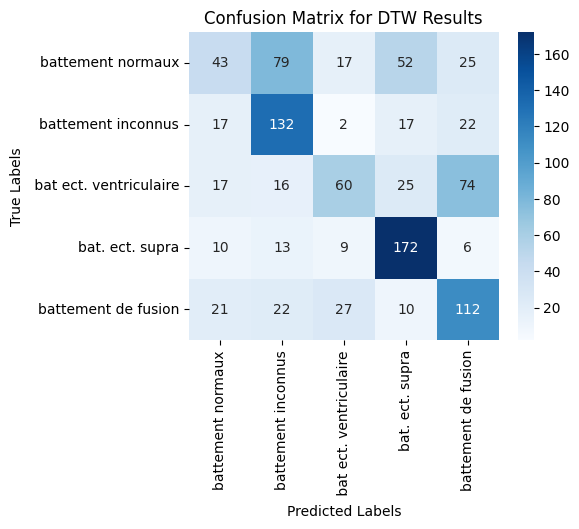

Accuracy du modèle DTW: 0.52
                         precision    recall  f1-score   support

      battement normaux       0.40      0.20      0.27       216
     battement inconnus       0.50      0.69      0.58       190
 bat ect. ventriculaire       0.52      0.31      0.39       192
        bat. ect. supra       0.62      0.82      0.71       210
    battement de fusion       0.47      0.58      0.52       192

               accuracy                           0.52      1000
              macro avg       0.50      0.52      0.49      1000
           weighted avg       0.50      0.52      0.49      1000



In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Calcul de la matrice de confusion
cm = confusion_matrix(PartitionDTW[:, 0], PartitionDTW[:, 1])

# Affichage de la matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DTW Results')
plt.show()

# Calcul de l'accuracy
accuracy = accuracy_score(PartitionDTW[:, 0], PartitionDTW[:, 1])
print(f"Accuracy du modèle DTW: {accuracy:.2f}")

# Rapport de classification
print(classification_report(PartitionDTW[:, 0], PartitionDTW[:, 1], target_names=label_name))

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

### Grid search - Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def grid_search_rf(data_features, labels, scaling=True):
    
    if scaling:
        scalerR = RobustScaler()
        data_features = scaler.fit_transform(data_features)
       
    # Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Initialisation du modèle
    rf_clf = RandomForestClassifier(random_state=42)

    # GridSearchCV avec validation croisée
    grid_search = GridSearchCV(
        rf_clf,
        param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    # Exécution de la recherche
    grid_search.fit(data_features, labels)


    print(f"✅ Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"🎯 Meilleur score : {grid_search.best_score_}")

    return grid_search.best_estimator_, grid_search.best_score_


In [27]:
%pip install scikit-learn

from sklearn.preprocessing import RobustScaler

data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models = {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_T"], acc = grid_search_rf(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_F"], acc = grid_search_rf(data, LabelF_train, False)


Note: you may need to restart the kernel to use updated packages.

🔍 Entraînement sur all features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.9240018025495879

🔍 Entraînement sur Temp features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.891501548550556

🔍 Entraînement sur Stat features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.8757506093164972

🔍 Entraînement sur Spec features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
🎯 Meilleur score : 0.9202519895341151



### Random Forest

In [28]:
# méthode de classification supervisé
# Random Forest
# Initialiser et entraîner le modèle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def rf_model(best_model, X_test, y_test, scaling=True):

    if scaling:
        scalerR = RobustScaler()
        X_test = scaler.fit_transform(X_test)

    # Prédictions sur les données de test
    y_pred = best_model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f" Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy



In [29]:
# Modèles avec toutes les données différentes

# Les modèles sont enregistré dans best_model

# Quand c'est False on a pas de scaling

# All features
print("\n All features : ")
y_pred_rf_all_T, accuracy_rf_all_T = rf_model(best_models["all_T"], DataFeatureTest, LabelF_test)
y_pred_rf_all_F, accuracy_rf_all_T = rf_model(best_models["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
print("\n Temporel features : ")
y_pred_rf_Temp_T, accuracy_rf_Temp_T = rf_model(best_models["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_rf_Temp_F, accuracy_rf_Temp_T = rf_model(best_models["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
print("\n Statistic features : ")
y_pred_rf_Stat_T, accuracy_rf_Stat_T = rf_model(best_models["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_rf_Stat_F, accuracy_rf_Stat_T = rf_model(best_models["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
print("\n Spectral features : ")
y_pred_rf_Spec_T, accuracy_rf_Spec_T = rf_model(best_models["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_rf_Spec_F, accuracy_rf_Spec_T = rf_model(best_models["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
print("\n ECG features : ")
y_pred_rf_ECG_T, accuracy_rf_ECG_T = rf_model(best_models["ECG_T"], DataECGTest, LabelF_test)
y_pred_rf_ECG_F, accuracy_rf_ECG_T = rf_model(best_models["ECG_F"], DataECGTest, LabelF_test, False)




 All features : 
 Accuracy du modèle RandomForest : 0.926
 Accuracy du modèle RandomForest : 0.933

 Temporel features : 
 Accuracy du modèle RandomForest : 0.896
 Accuracy du modèle RandomForest : 0.901

 Statistic features : 
 Accuracy du modèle RandomForest : 0.89
 Accuracy du modèle RandomForest : 0.888

 Spectral features : 
 Accuracy du modèle RandomForest : 0.918
 Accuracy du modèle RandomForest : 0.918

 ECG features : 
 Accuracy du modèle RandomForest : 0.91
 Accuracy du modèle RandomForest : 0.977


### Grid search KNN

In [30]:
# Grid search pour trouver les meilleurs paramètres pour notre KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def grid_search_knn(data_features, labels, scaling=True):
    
    if scaling:
        scalerR = RobustScaler()
        data_features = scaler.fit_transform(data_features)
        
    # Définition du modèle
    knn = KNeighborsClassifier()
    
    # Définition de la grille de recherche
    param_grid = {
        "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
    
    # Initialisation de GridSearchCV
    grid_search_knn = GridSearchCV(
        knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    
    # Exécution de GridSearchCV
    grid_search_knn.fit(data_features, labels)
    
    print("Meilleurs hyperparamètres :", grid_search_knn.best_params_)
    print("Meilleur score :", grid_search_knn.best_score_)
    
    return grid_search_knn.best_estimator_, grid_search_knn.best_score_
    


In [31]:
data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models_knn = {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_T"], acc = grid_search_knn(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_F"], acc = grid_search_knn(data, LabelF_train, False)


🔍 Entraînement sur all features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.9252499999999999

🔍 Entraînement sur Temp features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.89125

🔍 Entraînement sur Stat features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.866

🔍 Entraînement sur Spec features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.92025

🔍 Entraînement sur ECG features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'

### KNN

In [32]:
# k-Nearest Neighbors
# méthode de classification supervisé

from sklearn.neighbors import KNeighborsClassifier
def knn_model(model,  X_test, y_test, scaling=True):
    if scaling:
        scalerR = RobustScaler()
        X_test = scaler.fit_transform(X_test)
        
    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"🏆 Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy
    
    

In [33]:
# Les modèles sont enregistrés dans best_model

# All features
y_pred_knn_all_T, accuracy_knn_all_T = knn_model(best_models_knn["all_T"], DataFeatureTest, LabelF_test)
y_pred_knn_all_F, accuracy_knn_all_T = knn_model(best_models_knn["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
y_pred_knn_Temp_T, accuracy_knn_Temp_T = knn_model(best_models_knn["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_knn_Temp_F, accuracy_knn_Temp_T = knn_model(best_models_knn["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
y_pred_knn_Stat_T, accuracy_knn_Stat_T = knn_model(best_models_knn["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_knn_Stat_F, accuracy_knn_Stat_T = knn_model(best_models_knn["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
y_pred_knn_Spec_T, accuracy_knn_Spec_T = knn_model(best_models_knn["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_knn_Spec_F, accuracy_knn_Spec_T = knn_model(best_models_knn["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
y_pred_knn_ECG_T, accuracy_knn_ECG_T = knn_model(best_models_knn["ECG_T"], DataECGTest, LabelF_test)
y_pred_knn_ECG_F, accuracy_knn_ECG_T = knn_model(best_models_knn["ECG_F"], DataECGTest, LabelF_test, False)


🏆 Accuracy du modèle RandomForest : 0.924
🏆 Accuracy du modèle RandomForest : 0.858
🏆 Accuracy du modèle RandomForest : 0.886
🏆 Accuracy du modèle RandomForest : 0.802
🏆 Accuracy du modèle RandomForest : 0.87
🏆 Accuracy du modèle RandomForest : 0.849
🏆 Accuracy du modèle RandomForest : 0.918
🏆 Accuracy du modèle RandomForest : 0.775
🏆 Accuracy du modèle RandomForest : 0.898
🏆 Accuracy du modèle RandomForest : 0.987


In [34]:
# Visualisation des matrices de confusion pour Kmeans de décision et DBScan
import seaborn as sns
import matplotlib.pyplot as plt

def display_matrix_s(m1,m2):
    plt.figure(figsize=(14, 6))
    
    # Matrice arbre de decision
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Random Forest")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title("Matrice de confusion - KNN")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()

In [35]:
from sklearn.metrics import confusion_matrix


# Random Forest
conf_matrix_rf_all_T = confusion_matrix(LabelF_test, y_pred_rf_all_T)
conf_matrix_rf_all_F = confusion_matrix(LabelF_test, y_pred_rf_all_F)

conf_matrix_rf_Temp_T = confusion_matrix(LabelF_test, y_pred_rf_Temp_T)
conf_matrix_rf_Temp_F = confusion_matrix(LabelF_test, y_pred_rf_Temp_F)

conf_matrix_rf_Spec_T = confusion_matrix(LabelF_test, y_pred_rf_Spec_T)
conf_matrix_rf_Spec_F = confusion_matrix(LabelF_test, y_pred_rf_Spec_F)

conf_matrix_rf_Stat_T = confusion_matrix(LabelF_test, y_pred_rf_Stat_T)
conf_matrix_rf_Stat_F = confusion_matrix(LabelF_test, y_pred_rf_Stat_F)

conf_matrix_rf_ECG_T = confusion_matrix(LabelF_test, y_pred_rf_ECG_T)
conf_matrix_rf_ECG_F = confusion_matrix(LabelF_test, y_pred_rf_ECG_F)



# KNN

conf_matrix_knn_all_T = confusion_matrix(LabelF_test, y_pred_knn_all_T)
conf_matrix_knn_all_F = confusion_matrix(LabelF_test, y_pred_knn_all_F)

conf_matrix_knn_Temp_T = confusion_matrix(LabelF_test, y_pred_knn_Temp_T)
conf_matrix_knn_Temp_F = confusion_matrix(LabelF_test, y_pred_knn_Temp_F)

conf_matrix_knn_Spec_T = confusion_matrix(LabelF_test, y_pred_knn_Spec_T)
conf_matrix_knn_Spec_F = confusion_matrix(LabelF_test, y_pred_knn_Spec_F)

conf_matrix_knn_Stat_T = confusion_matrix(LabelF_test, y_pred_knn_Stat_T)
conf_matrix_knn_Stat_F = confusion_matrix(LabelF_test, y_pred_knn_Stat_F)

conf_matrix_knn_ECG_T = confusion_matrix(LabelF_test, y_pred_knn_ECG_T)
conf_matrix_knn_ECG_F = confusion_matrix(LabelF_test, y_pred_knn_ECG_F)



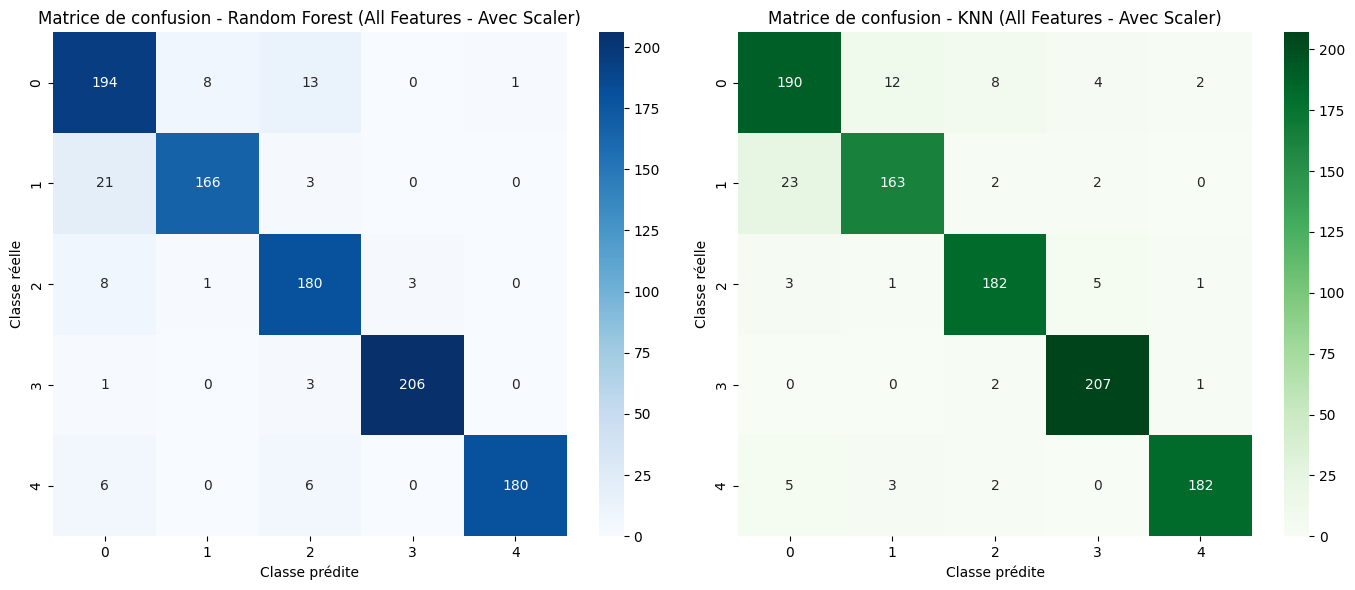

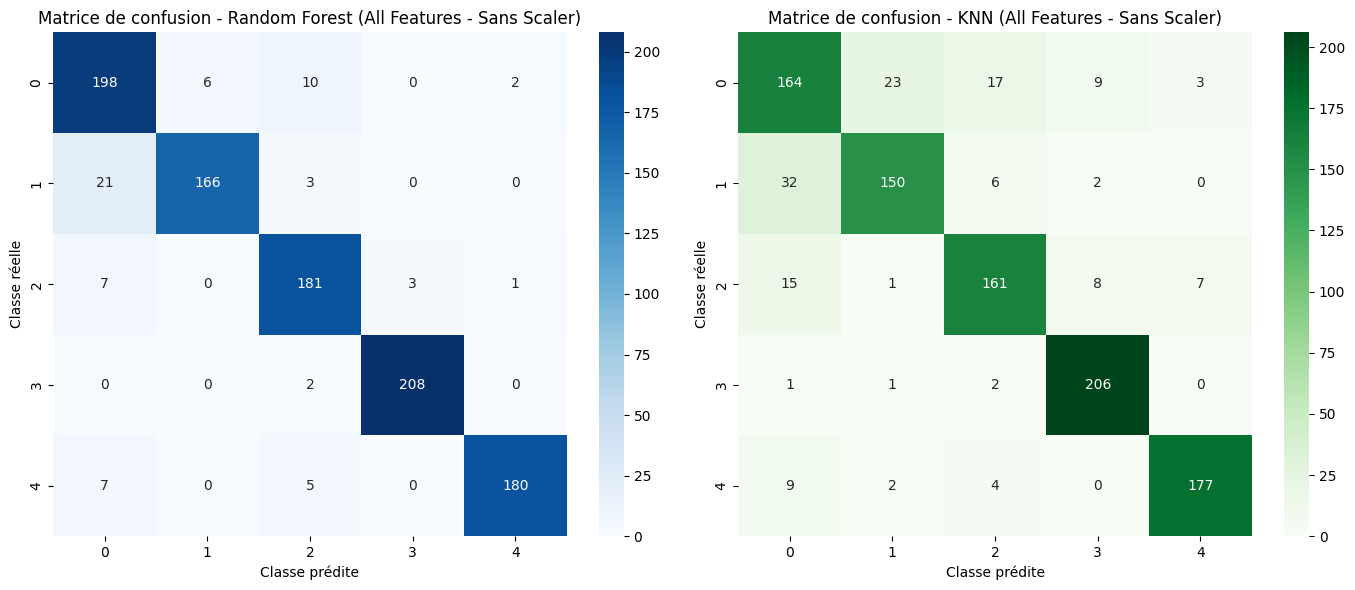

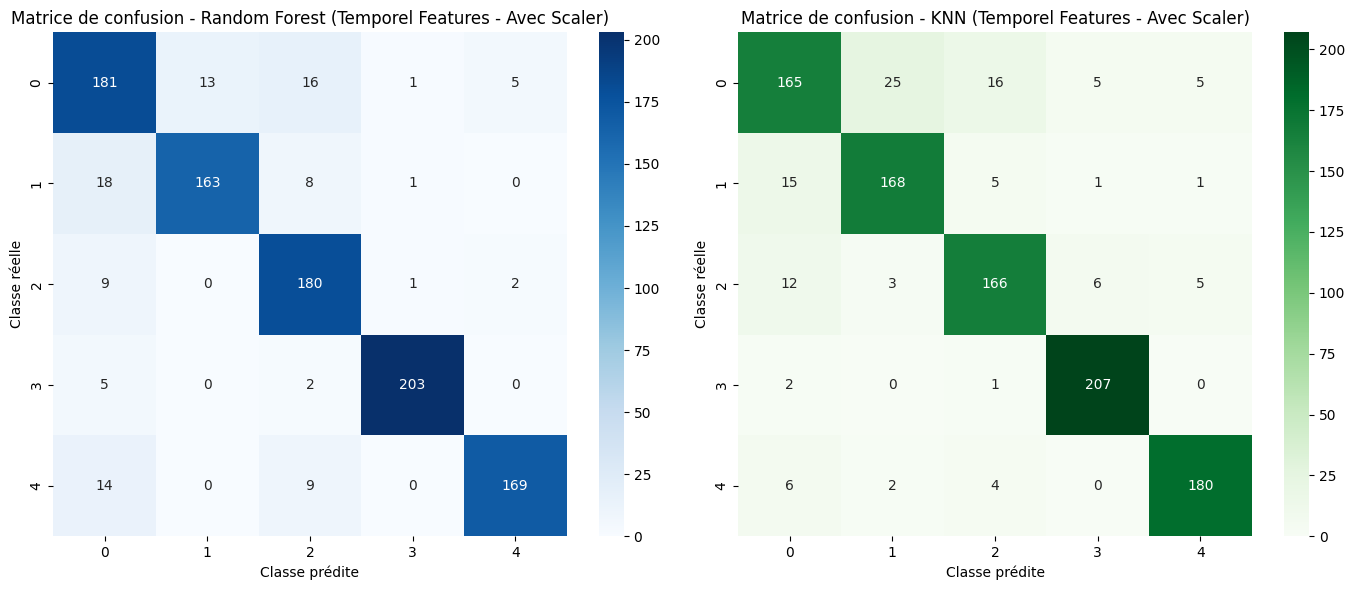

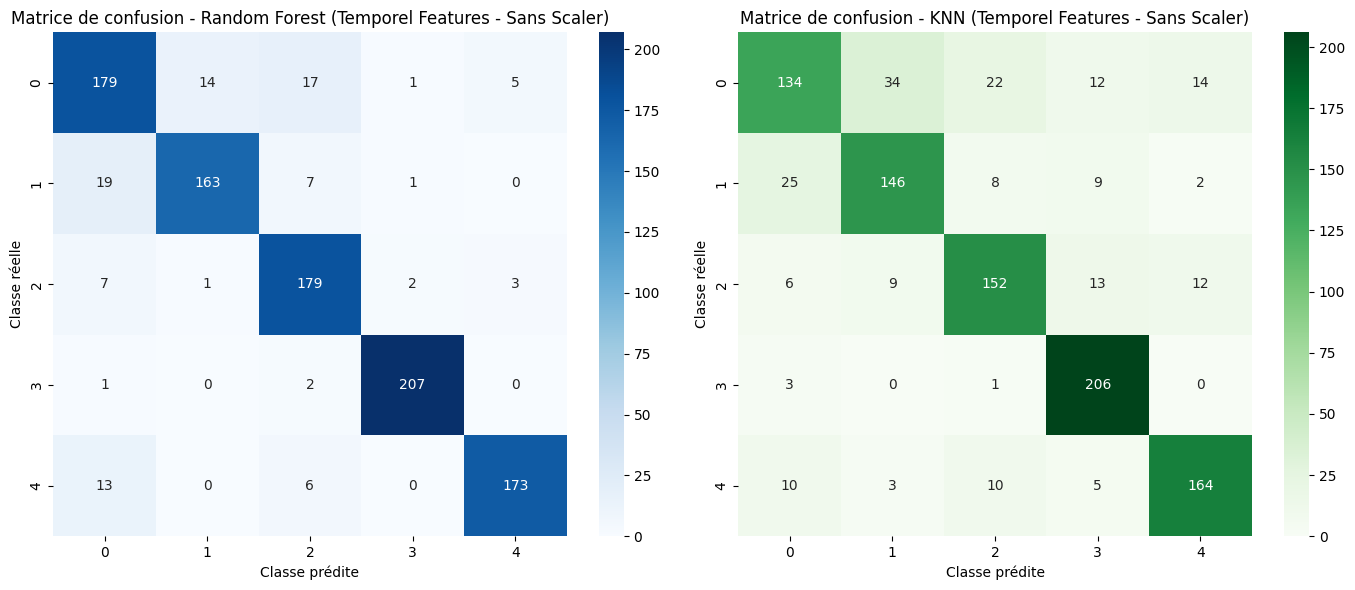

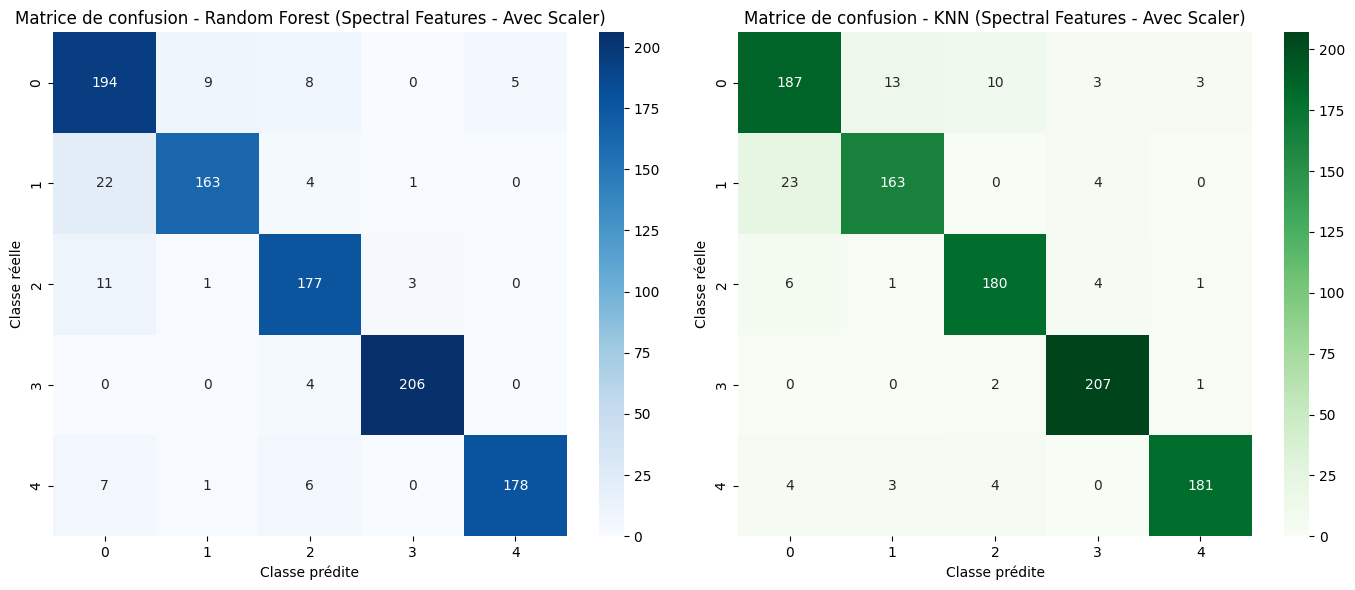

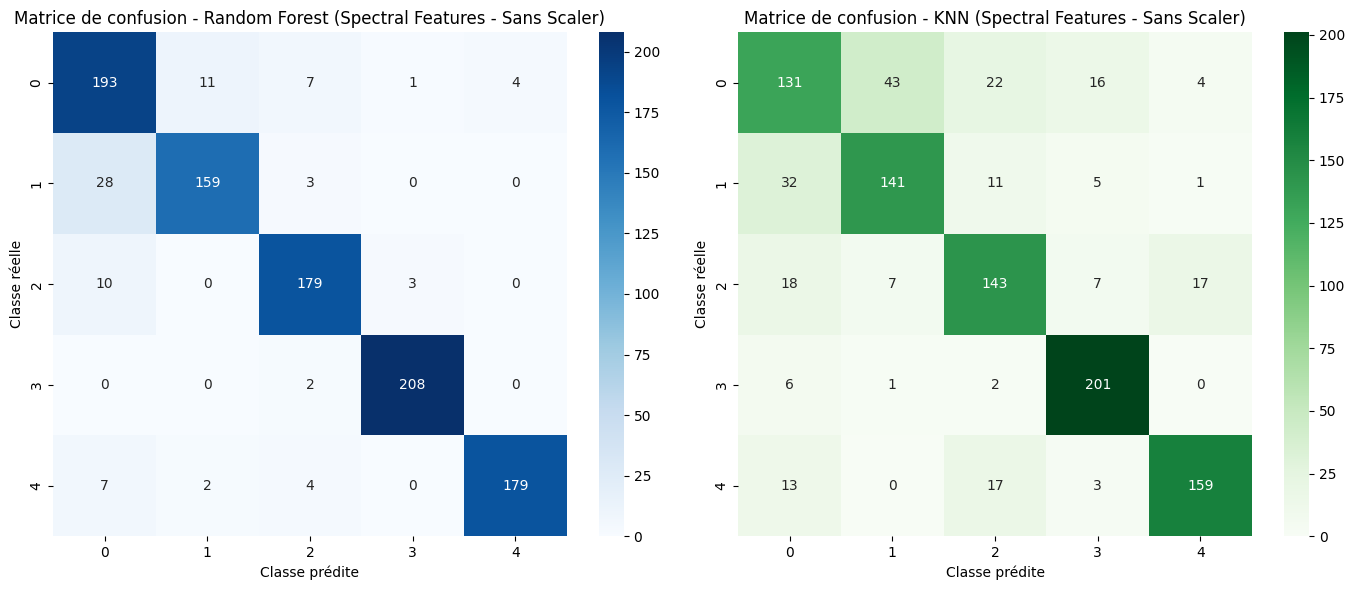

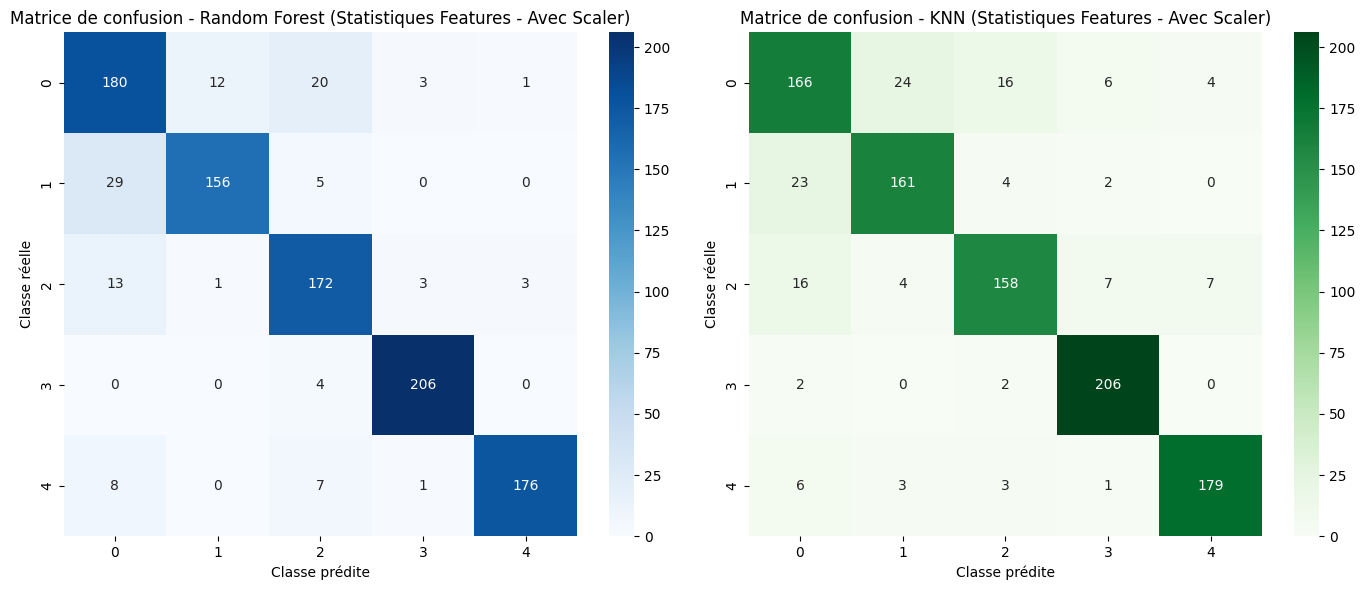

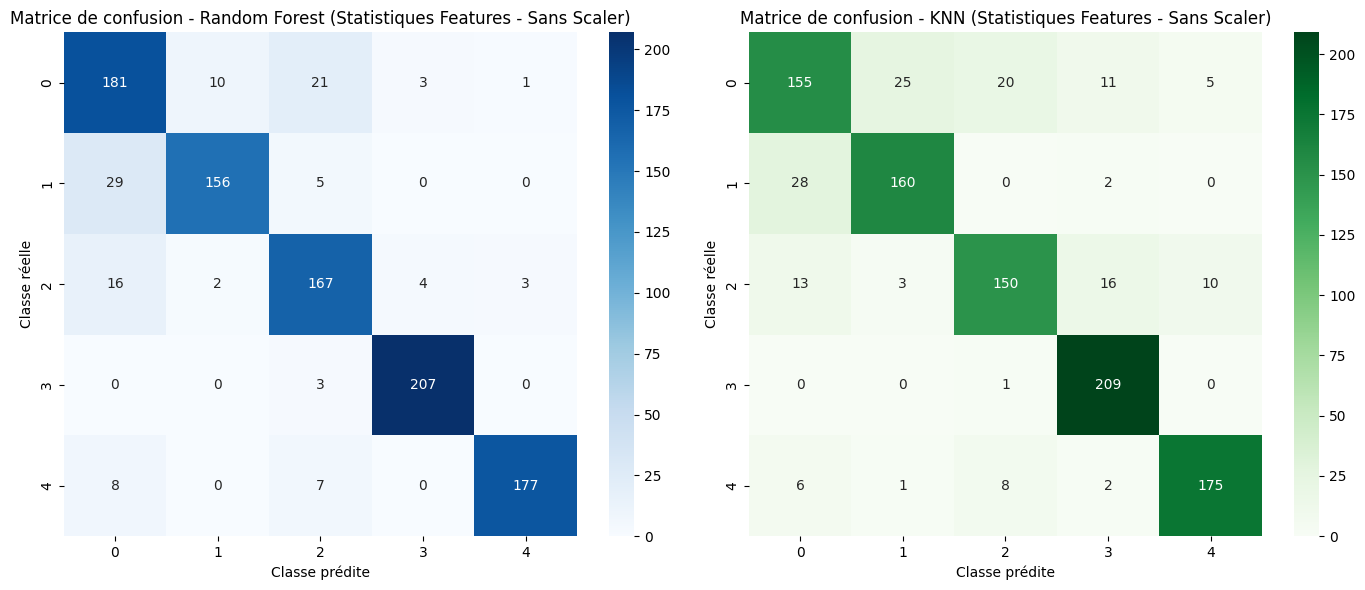

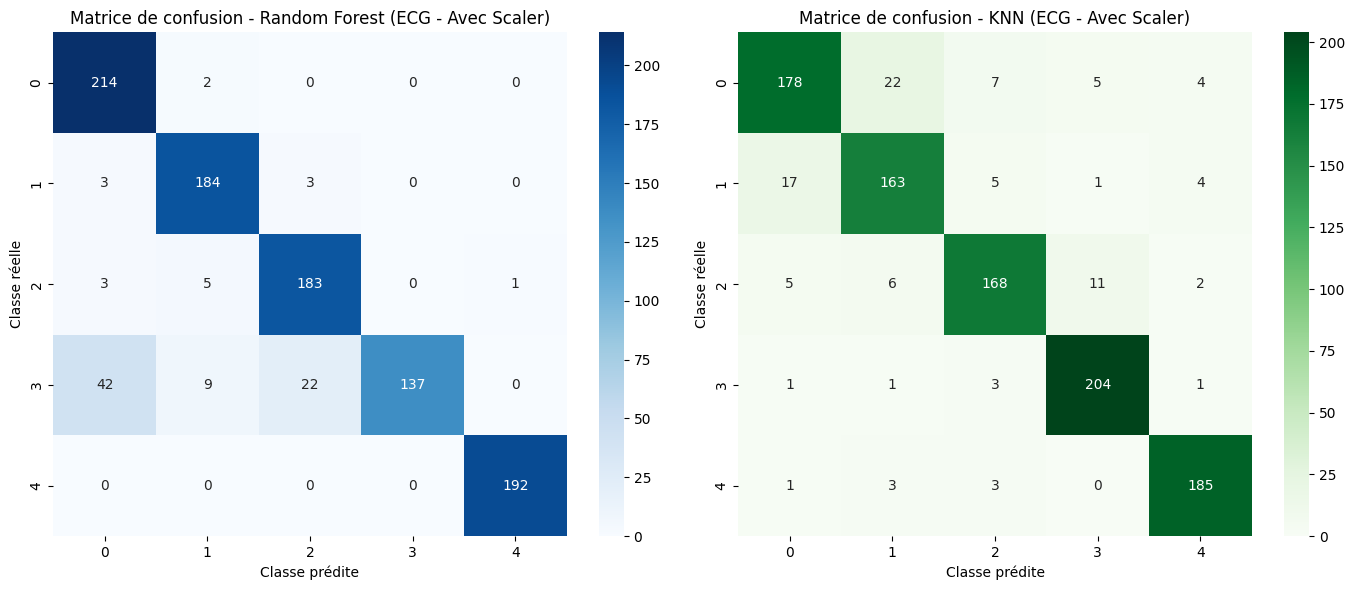

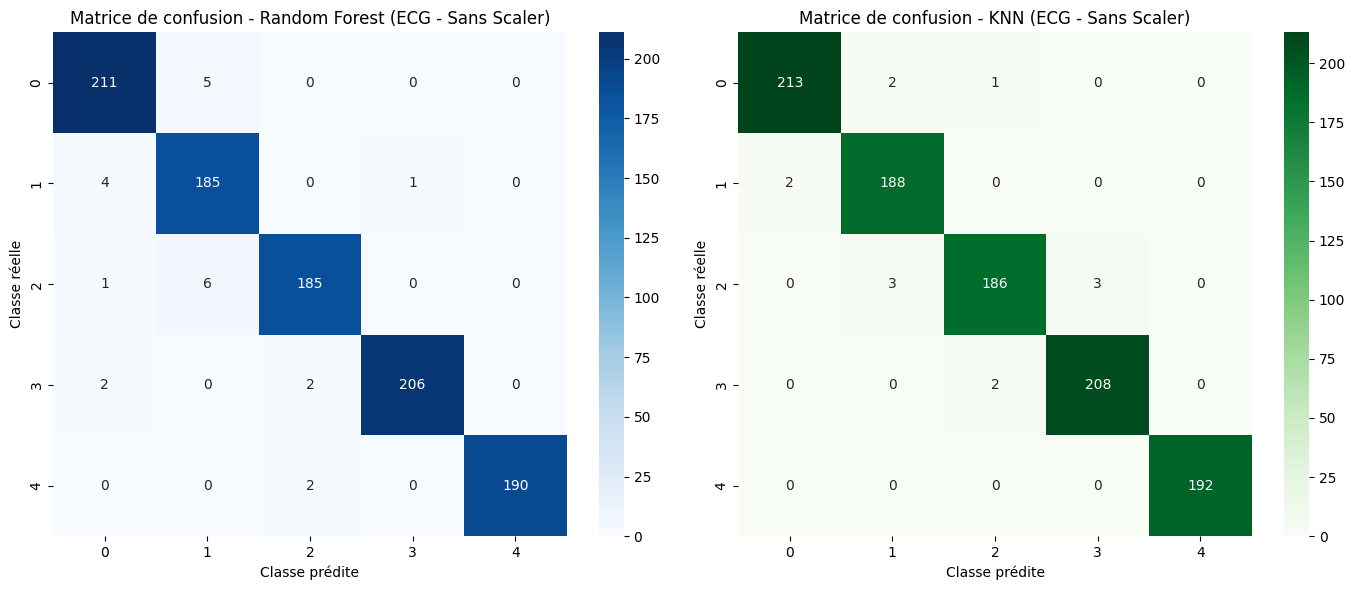

In [36]:
# Display matrice de confusion

def display_matrix_s(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Random Forest ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - KNN ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Appels de la fonction avec les bonnes matrices et titres
display_matrix_s(conf_matrix_rf_all_T, conf_matrix_knn_all_T, "All Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_all_F, conf_matrix_knn_all_F, "All Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Temp_T, conf_matrix_knn_Temp_T, "Temporel Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Temp_F, conf_matrix_knn_Temp_F, "Temporel Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Spec_T, conf_matrix_knn_Spec_T, "Spectral Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Spec_F, conf_matrix_knn_Spec_F, "Spectral Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Stat_T, conf_matrix_knn_Stat_T, "Statistiques Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Stat_F, conf_matrix_knn_Stat_F, "Statistiques Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_ECG_T, conf_matrix_knn_ECG_T, "ECG - Avec Scaler")
display_matrix_s(conf_matrix_rf_ECG_F, conf_matrix_knn_ECG_F, "ECG - Sans Scaler")


## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.  
 <b>Kmeans</b> et <b>Clustering Hierarchique</b>

### Score matrice de confusion

In [37]:
def conf_matrix_score(LabelF_train,y_pred):
    """
    Calcule le score d'une matrice de confusion.
    Le score est défini comme la somme des bonnes classifications par ligne divisées par le total de la ligne.
    fonction de score assez basique mais utile pour le réglage des hyper paramètres à partir
    des matrices de confusion
    """
    LabelF_train1 = LabelF_train.astype(int)

    # Conversion des clusters en labels réels
    y_pred_labels_temp = correspondance(y_pred, LabelF_train1)
    
    conf_matrix = confusion_matrix(LabelF_train, y_pred_labels_temp)
    
    score = 0
    for i in range(conf_matrix.shape[0]):
        total_in_row = np.sum(conf_matrix[i, :])
        if total_in_row > 0:
            score += conf_matrix[i, i] / total_in_row
    
    return (score / conf_matrix.shape[0])

### Kmeans recherche des meilleurs hyperparamètres

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def hyper_search_kmeans(data_features):
    # Normalisation Min-Max (valeurs entre 0 et 1)
    scalerM = MinMaxScaler()
    DataFeatureApp_scaledM = scaler.fit_transform(data_features)
    
    # Normalisation robuste (élimine l'effet des outliers)
    scalerR = RobustScaler()
    DataFeatureApp_scaledR = scaler.fit_transform(data_features)
    
    # Normalisation Standard
    scalerS = StandardScaler()
    DataFeatureApp_scaledS = scaler.fit_transform(data_features) 
    
    # Hyperparamètres
    param_grid = {
        "init": ["k-means++", "random"],
        "n_init": [10, 20, 30],
        "max_iter": [300, 500, 1000],
        "algorithm": ["lloyd", "elkan"],
        "tol": [1e-3, 1e-4, 1e-5],
        "data": {
           "RobustScaler": DataFeatureApp_scaledR,
            "StandardScaler" : DataFeatureApp_scaledS, 
            "MinMaxScaler" : DataFeatureApp_scaledM,
            "dataWithoutScale":data_features
        }
        
    }
    
    # Initialisation des meilleures valeurs
    best_confmatrix = 0
    best_params = {}
    
    # Teste des hyperparamètres
    for init in param_grid["init"]:
        for n_init in param_grid["n_init"]:
            for max_iter in param_grid["max_iter"]:
                for algorithm in param_grid["algorithm"]:
                    for tol in param_grid["tol"]: 
                        for scaler_name, data in param_grid["data"].items():
                            
                            # Création et entraînement du modèle K-Means
                            kmeans = KMeans(
                                n_clusters=5, init=init, n_init=n_init, 
                                max_iter=max_iter, algorithm=algorithm, 
                                tol=tol, random_state=42
                            )
    
                            
                            y_pred_km = kmeans.fit_predict(data)
                                
    
                            score_matrix = conf_matrix_score(LabelF_train, y_pred_km )
    
                            # Mise à jour paramètres
                            if score_matrix > best_confmatrix:
                                best_confmatrix = score_matrix
                                best_params = {
                                    "init": init,
                                    "n_init": n_init,
                                    "max_iter": max_iter,
                                    "algorithm": algorithm,
                                    "tol": tol,
                                    "data":scaler_name
                                }
    
    # Affichage best paramètres
    print(f"\n Meilleurs paramètres trouvés : {best_params} \n et meilleur score : {best_confmatrix}")


In [39]:
# Obtenir les meilleurs hyperparametres pour chaque type de données
dataList = [DataFeatureApp, DataFeatureAppTemp, DataFeatureAppStat, DataFeatureAppSpec, DataECGApp]

for d in dataList:
    hyper_search_kmeans(d)


 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5225495010823165

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.0001, 'data': 'RobustScaler'} 
 et meilleur score : 0.4565443239119974

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5527874441983651

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5779553117055729

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
 et meilleur score : 0.6358971724119225


### Kmeans

In [40]:
# méthode non supervisé
# kmeans

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def kmeans_model(data_features, params,scaling= True):
    if scaling:
        # Normalisation robuste (élimine l'effet des outliers)
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    kmeans = KMeans(**params)
    kmeans.fit(data_features)
    
    # Prédictions des clusters
    y_pred_km = kmeans.predict(data_features)
    
    LabelF_test1 = LabelF_test.astype(int)
    
    # Conversion des clusters en labels réels
    y_pred_labels_km = correspondance(y_pred_km, LabelF_test1)
    
    # Calcul de l'accuracy
    accuracy_km = accuracy_score(LabelF_test, y_pred_labels_km)
    
    # Calcul matrix score
    score_matrix_km = conf_matrix_score(LabelF_test, y_pred_km)
    
    #print(f"accuracy score de kmean : {accuracy_km}")
    return y_pred_km, accuracy_km, y_pred_labels_km, score_matrix_km

In [41]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 1e-05, "random_state": 42},
    "Temp":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Stat":{"n_clusters": 5, 'init': 'random', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Spec":{"n_clusters": 5,'init':'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "ECG": {"n_clusters": 5, 'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42}
}

# All features
y_pred_km_all_T, accuracy_km_all_T, y_pred_labels_km_all_T, score_matrix_km_all_T = kmeans_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_km_all_T} ; {score_matrix_km_all_T}")
y_pred_km_all_F, accuracy_km_all_F, y_pred_labels_km_all_F, score_matrix_km_all_F = kmeans_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_km_all_F } ; {score_matrix_km_all_F}")


# Temporel features
y_pred_km_Temp_T, accuracy_km_Temp_T, y_pred_labels_km_Temp_T, score_matrix_km_Temp_T = kmeans_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_km_Temp_T} ; {score_matrix_km_Temp_T}")
y_pred_km_Temp_F, accuracy_km_Temp_F, y_pred_labels_km_Temp_F, score_matrix_km_Temp_F = kmeans_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_km_Temp_F } ; {score_matrix_km_Temp_F}")

# Statistiques features
y_pred_km_Stat_T, accuracy_km_Stat_T, y_pred_labels_km_Stat_T, score_matrix_km_Stat_T = kmeans_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_km_Stat_T} ; {score_matrix_km_Stat_T}")
y_pred_km_Stat_F, accuracy_km_Stat_F, y_pred_labels_km_Stat_F, score_matrix_km_Stat_F = kmeans_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_km_Stat_F } ; {score_matrix_km_Stat_F}")

# Spectral features
y_pred_km_Spec_T, accuracy_km_Spec_T, y_pred_labels_km_Spec_T, score_matrix_km_Spec_T = kmeans_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_km_Spec_T} ; {score_matrix_km_Spec_T}")
y_pred_km_Spec_F, accuracy_km_Spec_F, y_pred_labels_km_Spec_F, score_matrix_km_Spec_F = kmeans_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_km_Spec_F } ; {score_matrix_km_Spec_F}")

# ECG sans features
y_pred_km_ECG_T, accuracy_km_ECG_T, y_pred_labels_km_ECG_T, score_matrix_km_ECG_T = kmeans_model(DataECGTest, model_grid["ECG"])
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_km_ECG_T} ; {score_matrix_km_ECG_T}")
y_pred_km_ECG_F, accuracy_km_ECG_F, y_pred_labels_km_ECG_F, score_matrix_km_ECG_F = kmeans_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_km_ECG_F } ; {score_matrix_km_ECG_F}")



Accuracy et matrix score de all features avec robust scaler : 0.551 ; 0.5583380325814536
Accuracy et matrix score de all features sans robust scaler : 0.408 ; 0.4086681982734614
Accuracy et matrix score de Temp features avec robust scaler : 0.528 ; 0.5237832428292954
Accuracy et matrix score de Temp features sans robust scaler : 0.462 ; 0.45915222082985246
Accuracy et matrix score de Stat features avec robust scaler : 0.503 ; 0.5088079573934837
Accuracy et matrix score de Stat features sans robust scaler : 0.461 ; 0.4707048872180451
Accuracy et matrix score de Spec features avec robust scaler : 0.57 ; 0.5786340852130325
Accuracy et matrix score de Spec features sans robust scaler : 0.409 ; 0.4097098649401281
Accuracy et matrix score de ECG features avec robust scaler : 0.415 ; 0.4142559523809524
Accuracy et matrix score de ECG features sans robust scaler : 0.628 ; 0.615448343079922


In [42]:
# Verifier que tous le monde a changer de classes correctement
def assert_label_change(oldL,newL):
    i0 = np.where(oldL == 0)[0]
    i1 = np.where(oldL == 1)[0]
    i2 = np.where(oldL == 2)[0]
    i3 = np.where(oldL == 3)[0]
    i4 = np.where(oldL == 4)[0]
    
    
    assert np.all(newL[i0] == newL[i0[0]])
    assert np.all(newL[i1] == newL[i1[0]])
    assert np.all(newL[i2] == newL[i2[0]])
    assert np.all(newL[i3] == newL[i3[0]])
    assert np.all(newL[i4] == newL[i4[0]])


### Clustering hierarchique recherche des meilleurs paramètres

In [43]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import RobustScaler
import numpy as np

def CH_search(data_features):
   
    # Normalisation robuste (élimine l'effet des outliers)
    scaler = RobustScaler()
    data_features = scaler.fit_transform(data_features)
    
    # Définition des hyperparamètres pour Agglomerative Clustering
    param_grid = [
        {"linkage": ["ward"], "metric": ["euclidean"]},  # Ward impose euclidean
        {"linkage": ["complete", "average", "single"], "metric": ["euclidean", "l1", "l2", "manhattan", "cosine"]}
    ]
    
    # Initialisation des meilleurs paramètres
    best_score = -1
    best_params = None
    
    # Test des hyperparamètres
    for params in ParameterGrid(param_grid):
        try:
            # Création du modèle 
            agglo = AgglomerativeClustering(n_clusters=5, linkage=params["linkage"], metric=params["metric"])
            
            # Prédictions des clusters
            y_pred_ch = agglo.fit_predict(data_features)
           
            score = conf_matrix_score(LabelF_train, y_pred_ch)  
    
            # Mise à jour du meilleur modèle
            if score > best_score:
                best_score = score
                best_params = params
        
        except ValueError as e:
            print(f"Ignoré : {params} --> Erreur : {e}")
    
    # Affichage des meilleurs paramètres
    print("\n Meilleurs paramètres trouvés :", best_params)
    print("f Meilleur score : {best_score} \n")


In [44]:
# Obtenir les meilleurs hyperparametres pour chaque type de données
dataList = {
           "All features": DataFeatureApp,
            "Temporel features" : DataFeatureAppTemp, 
            "Statistic features" : DataFeatureAppStat,
            "Spectral features":DataFeatureAppSpec,
            "ECG": DataECGApp
        }

for scaler_name, data in dataList.items():
    print(scaler_name)
    CH_search(data)

All features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

Temporel features

 Meilleurs paramètres trouvés : {'linkage': 'complete', 'metric': 'cosine'}
f Meilleur score : {best_score} 

Statistic features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

Spectral features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

ECG

 Meilleurs paramètres trouvés : {'linkage': 'average', 'metric': 'cosine'}
f Meilleur score : {best_score} 



### Clustering Hierarchique

In [45]:
from sklearn.cluster import AgglomerativeClustering


def CH_model(data_features, params,scaling= True):
    if scaling:
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    # model
    agglo = AgglomerativeClustering(n_clusters=5, **params)  # Peut tester aussi 'complete', 'average'
    
    # classification
    y_pred_ch = agglo.fit_predict(data_features)
    
    # Convertir en Int
    LabelF_test1 = LabelF_test.astype(int)
        
    # Conversion des clusters en labels réels
    y_pred_labels_ch = correspondance(y_pred_ch, LabelF_test1)
    
    # Calcul matrix score
    score_matrix_ch = conf_matrix_score(LabelF_test, y_pred_ch)
    
    # Calcul de l'accuracy
    accuracy_ch = accuracy_score(LabelF_test, y_pred_labels_ch)
    
    #print(f"accuracy score de CH : {accuracy_ch}")
    return y_pred_ch, accuracy_ch, y_pred_labels_ch, score_matrix_ch


In [46]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{'linkage': 'ward', 'metric': 'euclidean'},
    "Temp":{'linkage': 'complete', 'metric': 'cosine'},
    "Stat":{'linkage': 'ward', 'metric': 'euclidean'},
    "Spec":{'linkage': 'ward', 'metric': 'euclidean'},
    "ECG":{'linkage': 'average', 'metric': 'cosine'}
}

# All features
y_pred_ch_all_T, accuracy_ch_all_T, y_pred_labels_ch_all_T, score_matrix_ch_all_T = CH_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_ch_all_T} ; {score_matrix_ch_all_T}")
y_pred_ch_all_F, accuracy_ch_all_F, y_pred_labels_ch_all_F, score_matrix_ch_all_F = CH_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_ch_all_F } ; {score_matrix_ch_all_F}")

# Temporel features
y_pred_ch_Temp_T, accuracy_ch_Temp_T, y_pred_labels_ch_Temp_T, score_matrix_ch_Temp_T = CH_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_ch_Temp_T} ; {score_matrix_ch_Temp_T}")
y_pred_ch_Temp_F, accuracy_ch_Temp_F, y_pred_labels_ch_Temp_F, score_matrix_ch_Temp_F = CH_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_ch_Temp_F } ; {score_matrix_ch_Temp_F}")

# Statistiques features
y_pred_ch_Stat_T, accuracy_ch_Stat_T, y_pred_labels_ch_Stat_T, score_matrix_ch_Stat_T = CH_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_ch_Stat_T} ; {score_matrix_ch_Stat_T}")
y_pred_ch_Stat_F, accuracy_ch_Stat_F, y_pred_labels_ch_Stat_F, score_matrix_ch_Stat_F = CH_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_ch_Stat_F } ; {score_matrix_ch_Stat_F}")

# Spectral features
y_pred_ch_Spec_T, accuracy_ch_Spec_T, y_pred_labels_ch_Spec_T, score_matrix_ch_Spec_T = CH_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_ch_Spec_T} ; {score_matrix_ch_Spec_T}")
y_pred_ch_Spec_F, accuracy_ch_Spec_F, y_pred_labels_ch_Spec_F, score_matrix_ch_Spec_F = CH_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_ch_Spec_F } ; {score_matrix_ch_Spec_F}")

# ECG sans features
y_pred_ch_ECG_T, accuracy_ch_ECG_T, y_pred_labels_ch_ECG_T, score_matrix_ch_ECG_T = CH_model(DataECGTest,  model_grid["ECG"] )
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_ch_ECG_T} ; {score_matrix_ch_ECG_T}")
y_pred_ch_ECG_F, accuracy_ch_ECG_F, y_pred_labels_ch_ECG_F, score_matrix_ch_ECG_F = CH_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_ch_ECG_F } ; {score_matrix_ch_ECG_F}")




Accuracy et matrix score de all features avec robust scaler : 0.559 ; 0.5660902255639098
Accuracy et matrix score de all features sans robust scaler : 0.388 ; 0.3893295739348371
Accuracy et matrix score de Temp features avec robust scaler : 0.547 ; 0.5458677944862156
Accuracy et matrix score de Temp features sans robust scaler : 0.352 ; 0.3501488095238095
Accuracy et matrix score de Stat features avec robust scaler : 0.516 ; 0.5232315162907268
Accuracy et matrix score de Stat features sans robust scaler : 0.442 ; 0.45171679197994996
Accuracy et matrix score de Spec features avec robust scaler : 0.478 ; 0.4996491228070175
Accuracy et matrix score de Spec features sans robust scaler : 0.389 ; 0.3804034391534391
Accuracy et matrix score de ECG features avec robust scaler : 0.391 ; 0.3876455026455027
Accuracy et matrix score de ECG features sans robust scaler : 0.315 ; 0.2979824561403509


### Matrice de confusion

In [47]:

# KMEANS
conf_matrix_km_all_T = confusion_matrix(LabelF_test, y_pred_labels_km_all_T)
conf_matrix_km_all_F = confusion_matrix(LabelF_test, y_pred_labels_km_all_F)

conf_matrix_km_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_T)
conf_matrix_km_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_F)

conf_matrix_km_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_T)
conf_matrix_km_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_F)

conf_matrix_km_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_T)
conf_matrix_km_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_F)

conf_matrix_km_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_T)
conf_matrix_km_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_F)


# Clustering hierarchique

conf_matrix_ch_all_T = confusion_matrix(LabelF_test, y_pred_labels_ch_all_T)
conf_matrix_ch_all_F = confusion_matrix(LabelF_test, y_pred_labels_ch_all_F)

conf_matrix_ch_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_T)
conf_matrix_ch_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_F)

conf_matrix_ch_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_T)
conf_matrix_ch_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_F)

conf_matrix_ch_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_T)
conf_matrix_ch_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_F)

conf_matrix_ch_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_T)
conf_matrix_ch_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_F)



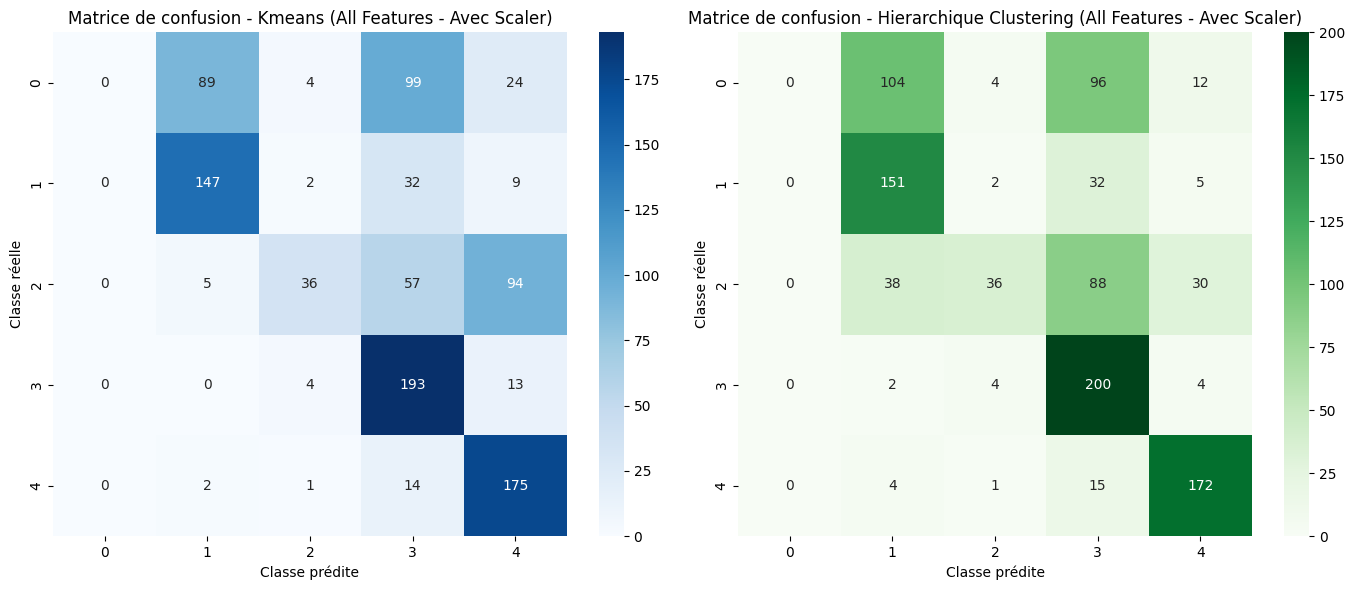

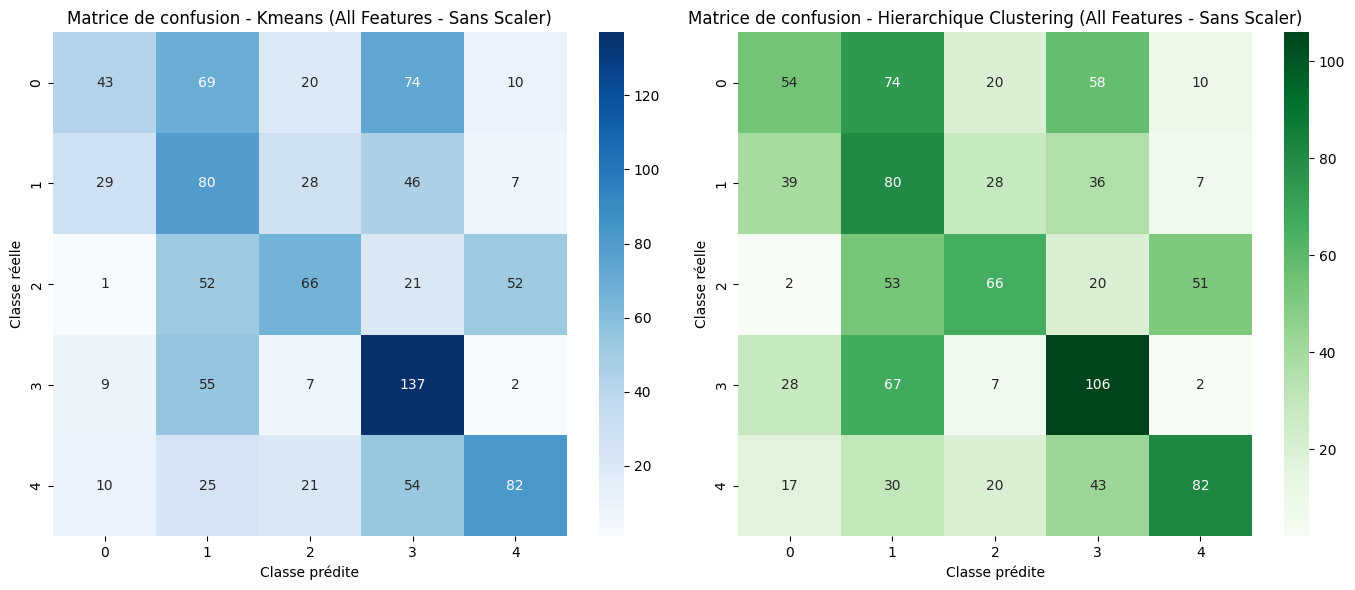

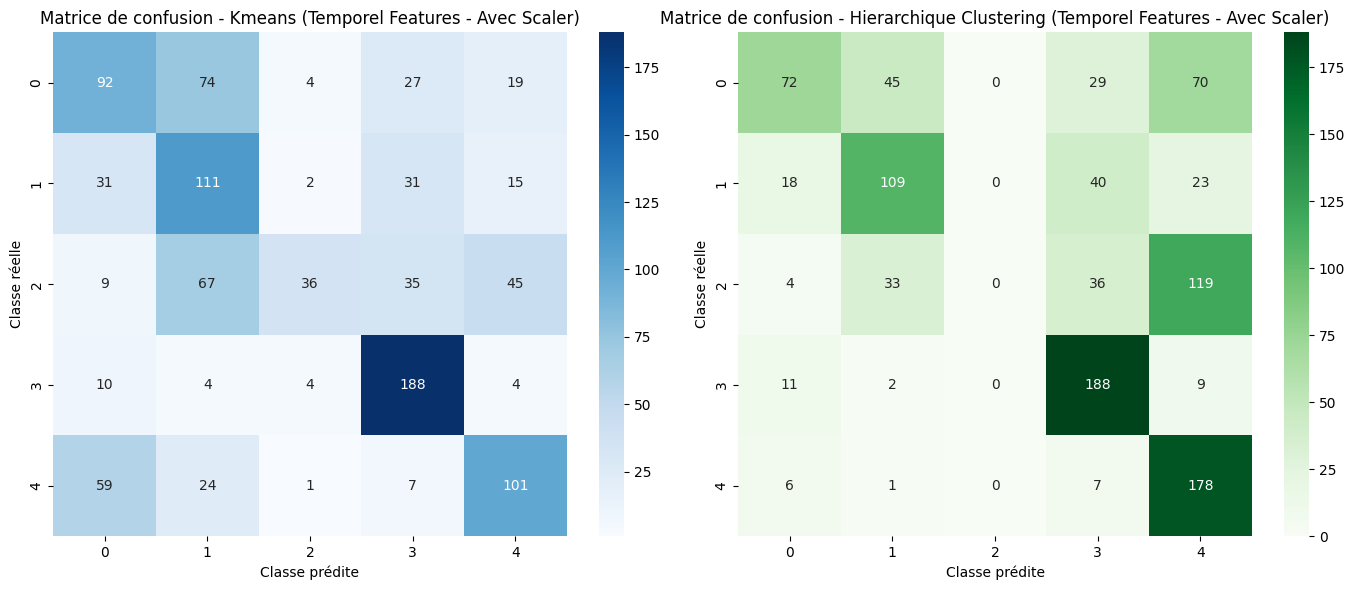

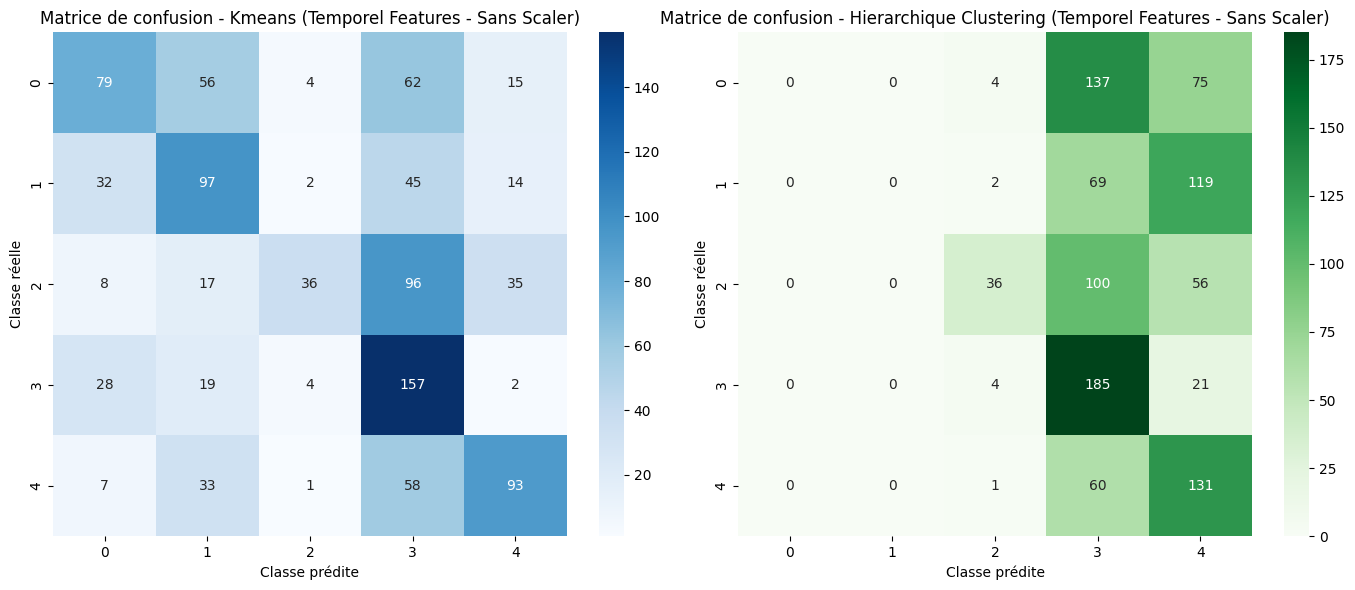

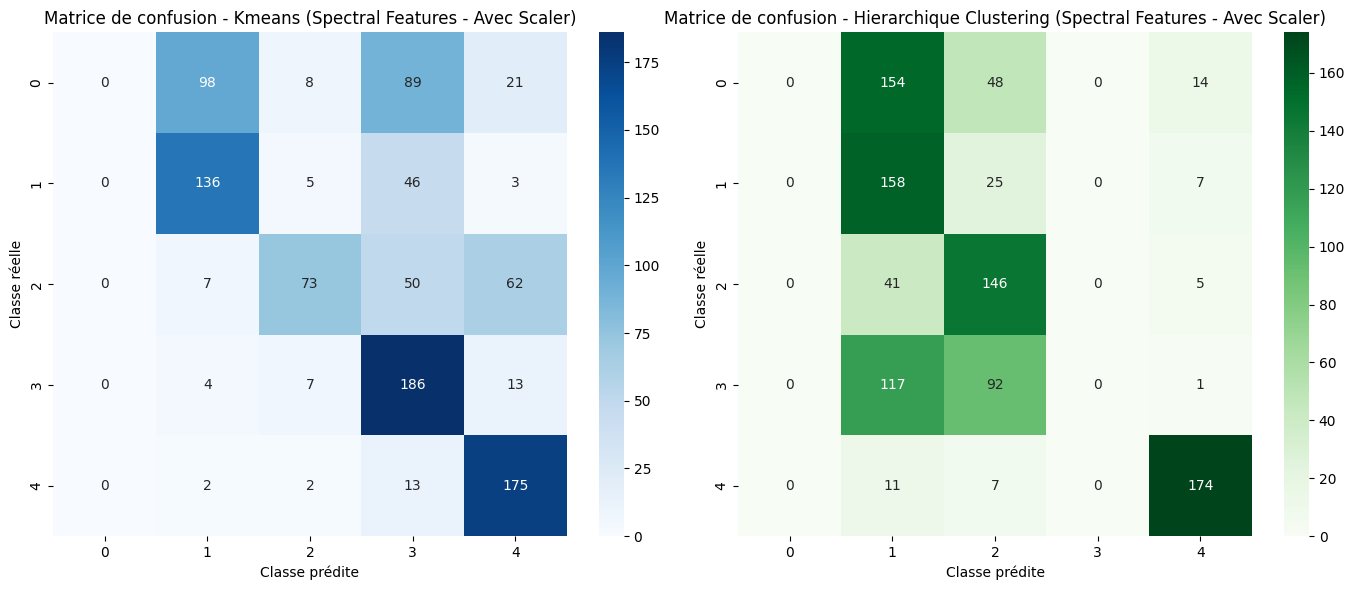

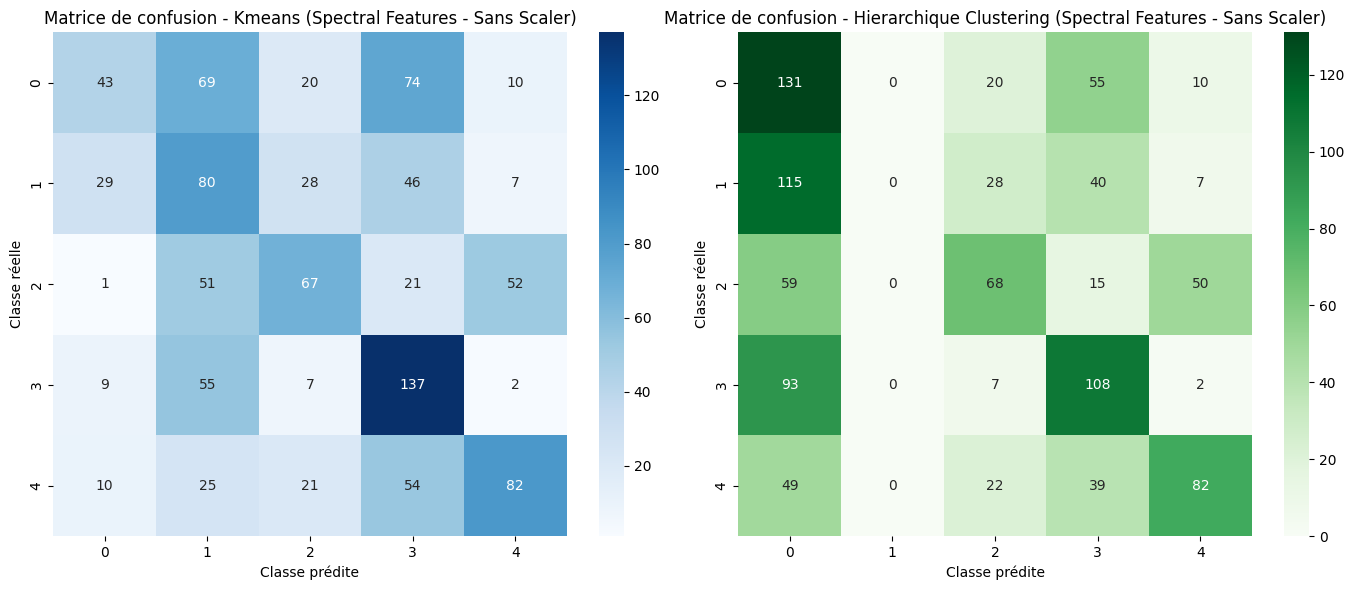

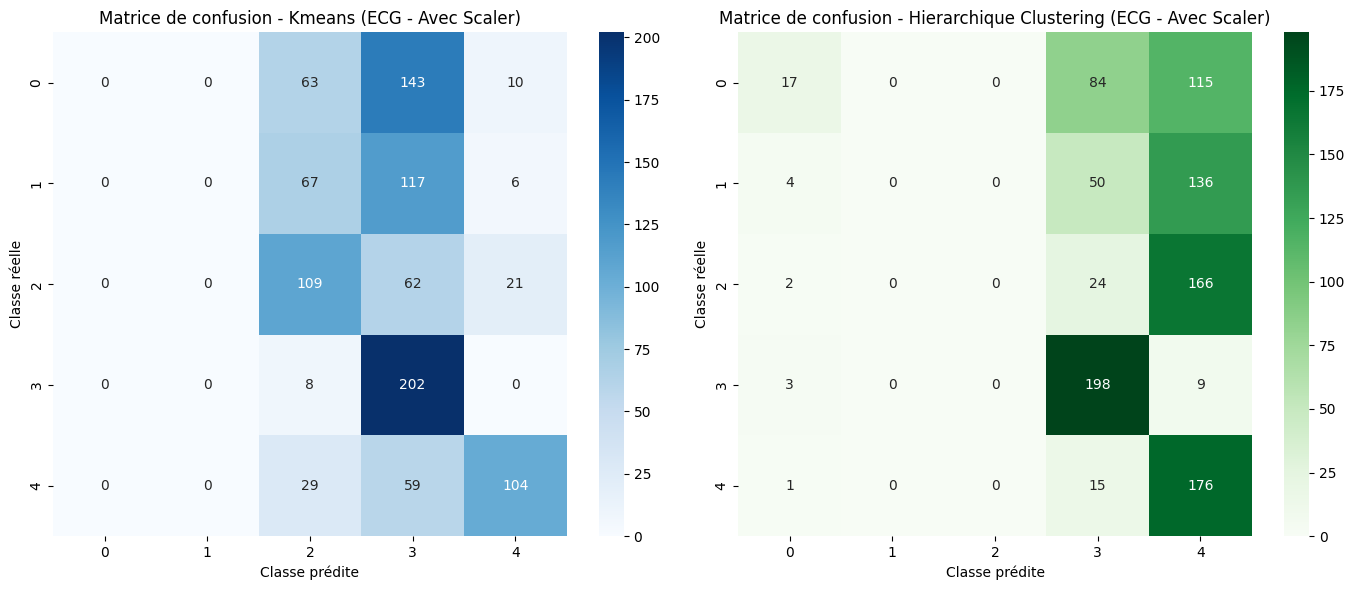

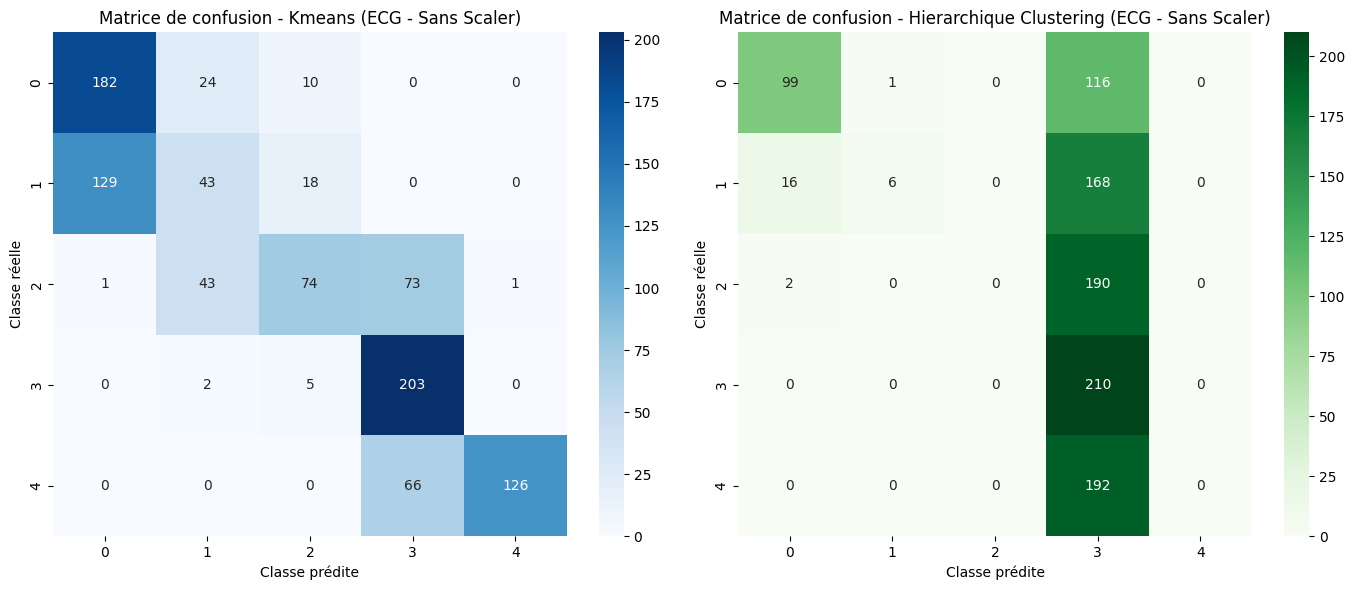

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display matrice de confusion

def display_matrix_ns(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Kmeans ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - Hierarchique Clustering ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Affichage des matrices de confusion
display_matrix_ns(conf_matrix_km_all_T, conf_matrix_ch_all_T, 
                 "All Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_all_F, conf_matrix_ch_all_F, 
                 "All Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Temp_T, conf_matrix_ch_Temp_T, 
                 "Temporel Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Temp_F, conf_matrix_ch_Temp_F, 
                 "Temporel Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Spec_T, conf_matrix_ch_Spec_T, 
                 "Spectral Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Spec_F, conf_matrix_ch_Spec_F, 
                "Spectral Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_ECG_T, conf_matrix_ch_ECG_T, 
                "ECG - Avec Scaler")

display_matrix_ns(conf_matrix_km_ECG_F, conf_matrix_ch_ECG_F, 
                 "ECG - Sans Scaler")



# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [50]:
from sklearn.decomposition import PCA

In [67]:
# Appliquer normalisation
scalers = {"all": StandardScaler(), "Temp": StandardScaler(), "Stat": StandardScaler(), "Spec": StandardScaler(), "ECG": StandardScaler()}

data_sets = {"all": (DataFeatureApp, DataFeatureTest),
             "Temp": (DataFeatureAppTemp, DataFeatureTestTemp),
             "Stat": (DataFeatureAppStat, DataFeatureTestStat),
             "Spec": (DataFeatureAppSpec, DataFeatureTestSpec),
             "ECG": (DataECGApp, DataECGTest)}

normalized_data = {}

# Normaliser les données
for key, (train, test) in data_sets.items():
    scaler = scalers[key]
    normalized_data[f"{key}_train"] = scaler.fit_transform(train)
    normalized_data[f"{key}_test"] = scaler.transform(test)

# Appliquer PCA avec 90% de variance
pca = PCA(n_components=0.90)
pca_transformed_data = {}

for key in data_sets.keys():
    pca_transformed_data[f"{key}_train_PCA"] = pca.fit_transform(normalized_data[f"{key}_train"])
    pca_transformed_data[f"{key}_test_PCA"] = pca.transform(normalized_data[f"{key}_test"])
    print(f"Nombre de composantes pour {key} features avec 90% de variance : {pca_transformed_data[f'{key}_train_PCA'].shape[1]}")

# Initialisation et entraînement du modèle Random Forest
def rf_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy

# Entraîner les modèles
best_models = {}
for key in data_sets.keys():
    best_models[key] = RandomForestClassifier().fit(pca_transformed_data[f"{key}_train_PCA"], LabelF_train)

# Tester et afficher les résultats
for key, model in best_models.items():
    print(f"\n{key} features with PCA90 :")
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred, accuracy = rf_model(model, X_test, LabelF_test)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    print(f"Matrice de confusion pour {key} :\n", conf_matrix)

Nombre de composantes pour all features avec 90% de variance : 23
Nombre de composantes pour Temp features avec 90% de variance : 7
Nombre de composantes pour Stat features avec 90% de variance : 6
Nombre de composantes pour Spec features avec 90% de variance : 20
Nombre de composantes pour ECG features avec 90% de variance : 20

all features with PCA90 :
Accuracy du modèle RandomForest : 0.907
Matrice de confusion pour all :
 [[184  10  12   3   7]
 [ 24 161   3   2   0]
 [ 10   0 178   3   1]
 [  0   0   3 207   0]
 [  6   1   7   1 177]]

Temp features with PCA90 :
Accuracy du modèle RandomForest : 0.879
Matrice de confusion pour Temp :
 [[164  22  18   7   5]
 [ 13 165  10   1   1]
 [  9   1 175   5   2]
 [  3   0   1 206   0]
 [ 13   2   8   0 169]]

Stat features with PCA90 :
Accuracy du modèle RandomForest : 0.847
Matrice de confusion pour Stat :
 [[161  26  23   3   3]
 [ 31 152   6   0   1]
 [ 14   1 163   8   6]
 [  0   1   4 205   0]
 [  9   1  13   3 166]]

Spec features wi


all features with PCA90 :
Accuracy du modèle RandomForest : 0.907
Matrice de confusion pour all :
 [[184  10  12   3   7]
 [ 24 161   3   2   0]
 [ 10   0 178   3   1]
 [  0   0   3 207   0]
 [  6   1   7   1 177]]


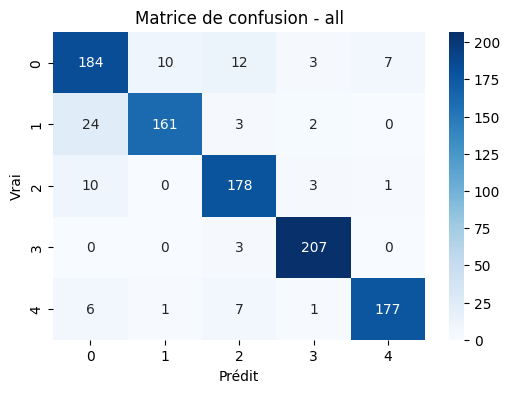


Temp features with PCA90 :
Accuracy du modèle RandomForest : 0.879
Matrice de confusion pour Temp :
 [[164  22  18   7   5]
 [ 13 165  10   1   1]
 [  9   1 175   5   2]
 [  3   0   1 206   0]
 [ 13   2   8   0 169]]


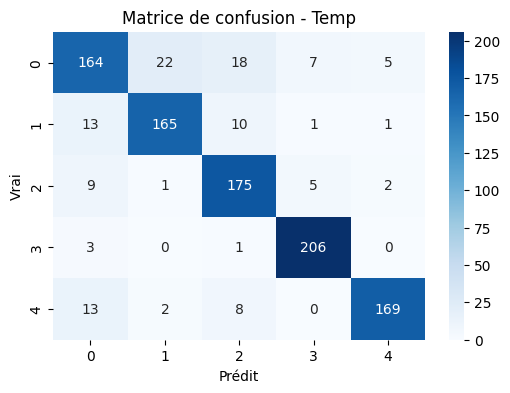


Stat features with PCA90 :
Accuracy du modèle RandomForest : 0.847
Matrice de confusion pour Stat :
 [[161  26  23   3   3]
 [ 31 152   6   0   1]
 [ 14   1 163   8   6]
 [  0   1   4 205   0]
 [  9   1  13   3 166]]


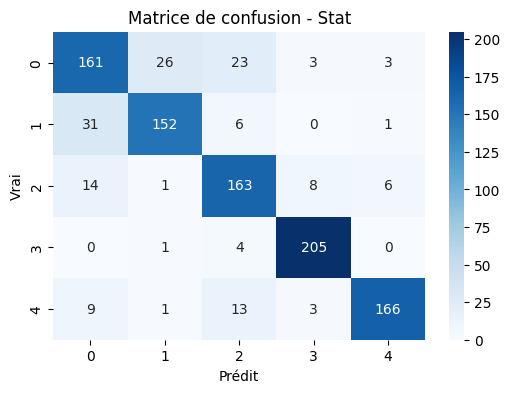


Spec features with PCA90 :
Accuracy du modèle RandomForest : 0.909
Matrice de confusion pour Spec :
 [[191  12   9   1   3]
 [ 31 155   3   1   0]
 [ 10   1 175   4   2]
 [  0   0   2 208   0]
 [  3   3   5   1 180]]


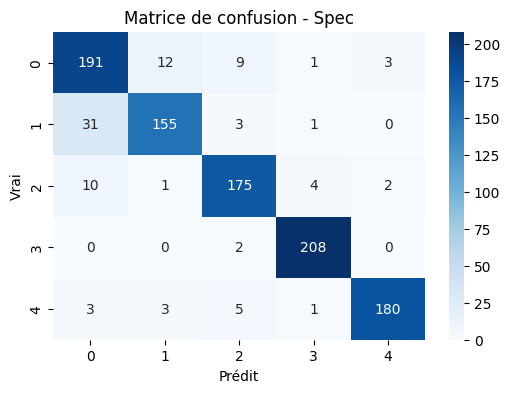


ECG features with PCA90 :
Accuracy du modèle RandomForest : 0.895
Matrice de confusion pour ECG :
 [[181  19  10   2   4]
 [ 22 163   2   2   1]
 [  4   6 166  12   4]
 [  4   0   2 204   0]
 [  4   1   6   0 181]]


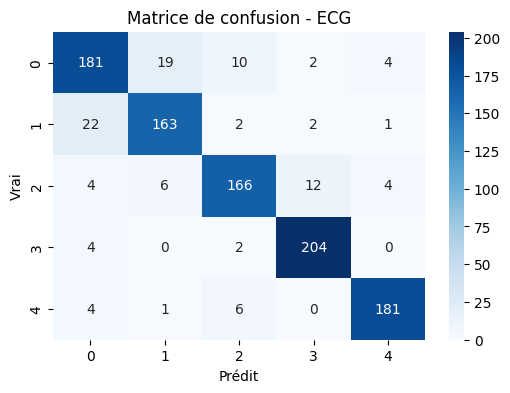

In [68]:
# Tester et afficher les résultats
for key, model in best_models.items():
    print(f"\n{key} features with PCA90 :")
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred, accuracy = rf_model(model, X_test, LabelF_test)
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    print(f"Matrice de confusion pour {key} :\n", conf_matrix)
    
    # Affichage de la matrice de confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - {key}")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()

### KNN


Meilleur modèle KNN pour all : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur modèle KNN pour Temp : {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Meilleur modèle KNN pour Stat : {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Meilleur modèle KNN pour Spec : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur modèle KNN pour ECG : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

all features with PCA90 using KNN:
Accuracy du modèle KNN : 0.908
Matrice de confusion pour all :
 [[177  20  11   5   3]
 [ 20 165   3   2   0]
 [  4   1 178   8   1]
 [  0   0   1 208   1]
 [  5   3   3   1 180]]


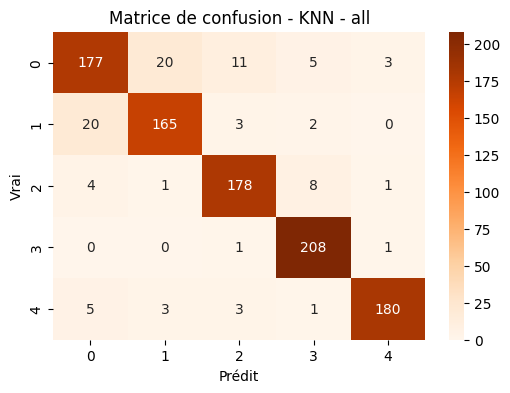


Temp features with PCA90 using KNN:
Accuracy du modèle KNN : 0.87
Matrice de confusion pour Temp :
 [[159  23  17  11   6]
 [ 13 164  10   1   2]
 [ 12   2 163  11   4]
 [  1   0   1 208   0]
 [  8   0   6   2 176]]


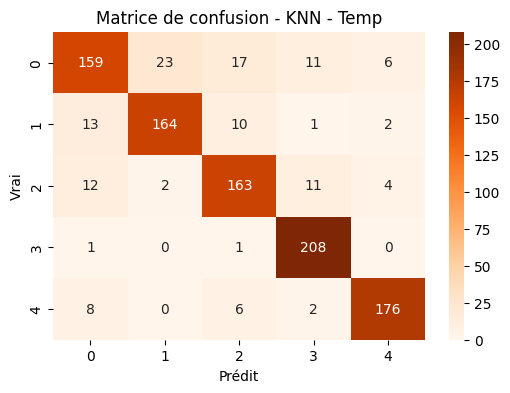


Stat features with PCA90 using KNN:
Accuracy du modèle KNN : 0.859
Matrice de confusion pour Stat :
 [[166  24  16   9   1]
 [ 20 157   4   6   3]
 [ 14   2 151  16   9]
 [  0   1   1 208   0]
 [  8   1   4   2 177]]


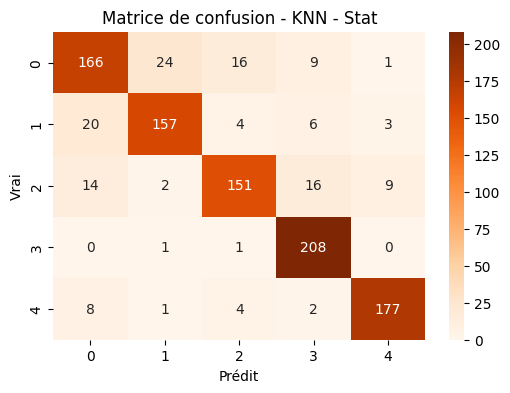


Spec features with PCA90 using KNN:
Accuracy du modèle KNN : 0.91
Matrice de confusion pour Spec :
 [[191  14   6   3   2]
 [ 27 158   2   2   1]
 [  6   1 174   8   3]
 [  0   0   1 208   1]
 [  4   3   4   2 179]]


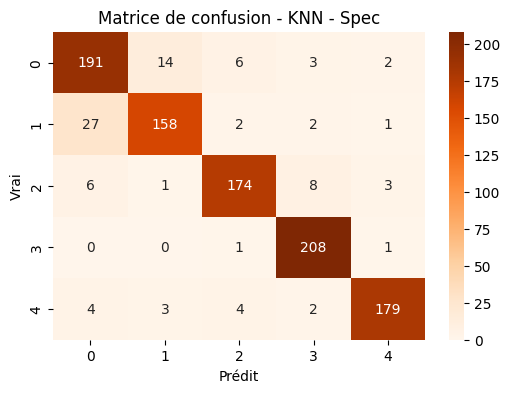


ECG features with PCA90 using KNN:
Accuracy du modèle KNN : 0.9
Matrice de confusion pour ECG :
 [[177  24   4   6   5]
 [ 17 165   4   2   2]
 [  5   5 166  13   3]
 [  1   1   2 206   0]
 [  1   3   2   0 186]]


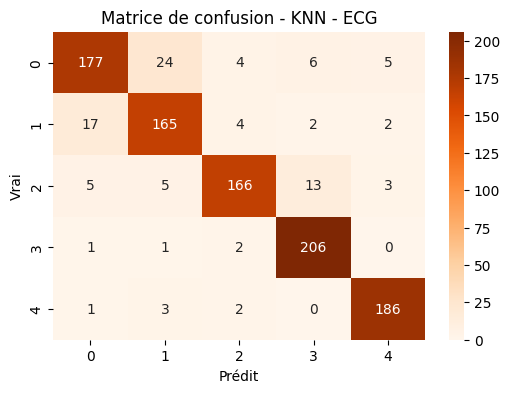

In [69]:
# Initialisation et entraînement du modèle KNN
param_grid = {
    "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

best_knn_models = {}

for key in data_sets.keys():
    knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy")
    knn.fit(pca_transformed_data[f"{key}_train_PCA"], LabelF_train)
    best_knn_models[key] = knn.best_estimator_
    print(f"Meilleur modèle KNN pour {key} : {knn.best_params_}")

# Tester et afficher les résultats pour KNN
for key, model in best_knn_models.items():
    print(f"\n{key} features with PCA90 using KNN:")
    X_test = pca_transformed_data[f"{key}_test_PCA"]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(LabelF_test, y_pred)
    print(f"Accuracy du modèle KNN : {accuracy}")
    conf_matrix = confusion_matrix(LabelF_test, y_pred)
    print(f"Matrice de confusion pour {key} :\n", conf_matrix)
    
    # Affichage de la matrice de confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")
    plt.title(f"Matrice de confusion - KNN - {key}")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)


# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
